## Task 04: Resampling and Hyperparameter Search (2022-04-05)


So far we have used softmax, SVC, and kNN models. Now we will create them again with the same 3-storey structure dataset but using hyperparameter tuning by randomized search. To that end, provide the following items:
1. Split your dataset into a) training/validation and b) test datasets (e.g. 60/40% ratio split)

2. Use randomized search with repeated cross-validation for hyperparameter tuning. Use e.g. 
    
    A. n_splits = 5, n_repeats = 50 [RepeatedKFold]

    B. n_iter = 100, n_jobs = -1 (will use all your cores), cv = (object you created with RepeatedKFold in 2.A), scoring = (choose a performance metric for classification problems), [RandomizedSearchCV]
    
    C. Suggestion: create estimator in a list and a list of dictionaries for param_distributions, as shown in the slides [RandomizedSearchCV]

3. Try to compare with the results obtained with the default configurations of each model constructor

In [1]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [2]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# task 03
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

#allow to print all variables in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from scipy import stats


### Opening data file and Separating parameters and labels

In [3]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)


### Building AR Model

In [4]:
modelOrder = 30

x2 = dataset[:,1,:].transpose() # acelerômetro: base
x3 = dataset[:,2,:].transpose() # acelerômetro: 1o andar
x4 = dataset[:,3,:].transpose() # acelerômetro: 2o andar
x5 = dataset[:,4,:].transpose() # acelerômetro: 3o andar

x2r = [] 
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x5r.append(res.params)

X1 = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
X1.shape

(850, 120)

### PCA analysis

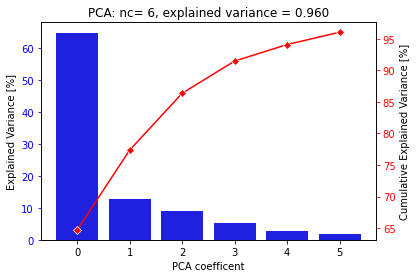

In [5]:
nComponents = 0.95  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X1)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i for i in range(len(pcaVariances))]

ax = sns.barplot(pcaComponents, pcaVariances*100, color='b');
ax2 = ax.twinx()
ax2 = sns.lineplot(pcaComponents, np.cumsum(pcaVariances)*100, color='r', marker='D');
ax.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: nc= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5])
ax.set_xlabel('PCA coefficent')
ax.set_ylabel('Explained Variance [%]')
ax2.set_ylabel('Cumulative Explained Variance [%]')
pass;

### Building x2 by transforming the x1 data with the previous PCA model and scaling X2

In [6]:
X2 = pca.fit_transform(X1)
X1_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X1)
X2_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X2)

### Creating pandas dataframe versions of the scaled x and x2, adding their labels

In [7]:
dfx1 = pd.DataFrame(X1_scaled)
dfx1 = dfx1.copy()
dfx1['label'] = y

dfx2 = pd.DataFrame(X2_scaled)
dfx2 = dfx2.copy()
dfx2['label'] = y

###  1. Split your dataset into a) training/validation and b) test datasets (e.g. 60/40% ratio split)

In [8]:
# From now on we dont use the '_scaled' for the test and train ensemples anymore
test_size = 0.40

X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=test_size, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=test_size, random_state=10)

### Softmax Linear Model (logistic regression with multiple classes) for the PCA reduced database

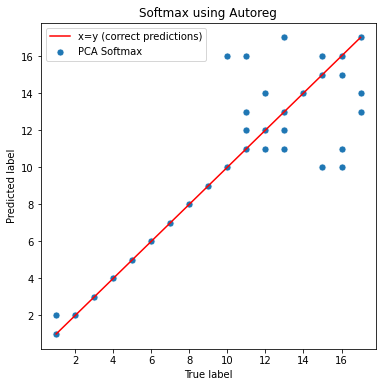

In [9]:
#PCA SOFTMAX
model_PCA_Soft = LogisticRegression(multi_class='multinomial', max_iter=200).fit(X2_train, y_train)

yPred2_train = model_PCA_Soft.predict(X2_train)
yPred2_test = model_PCA_Soft.predict(X2_test)

fig = plt.figure(figsize=(6, 6));
x=np.arange(1,18,1);

ax = sns.scatterplot(y_test,yPred2_test, s=50);
ax.set_xlabel('True label');
ax.set_ylabel('Predicted label');
ax=sns.lineplot(x=x, y=x, color='r');
ax.legend(['x=y (correct predictions)','PCA Softmax']);

ax.set_title('Softmax using Autoreg');

___

### Fitting SVM and k-NN with their default params, then saving it to a results Dataframe

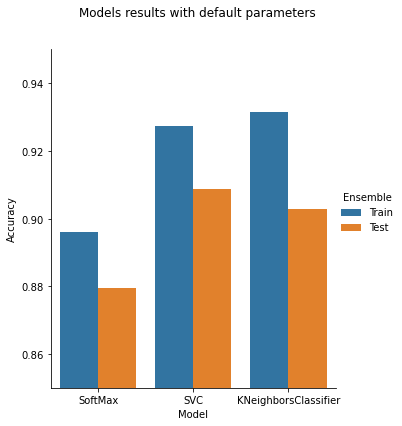

In [42]:
# Previous Model Softmax PCA
dfResults = pd.DataFrame({
        'Model': ['SoftMax'], 
        'Hyperparam': ['Default'], 
        'Train': accuracy_score(y_train, yPred2_train), 
        'Test': accuracy_score(y_test, yPred2_test)
        })

for i,model in enumerate([SVC(),KNeighborsClassifier()]):
    modelTrained = model.fit(X2_train, y_train)
    
    yPred_train = modelTrained.predict(X2_train)
    yPred_test = modelTrained.predict(X2_test)

    dfResults = dfResults.append(pd.DataFrame({
        'Model': [str(model).split('(')[0]],
        'Hyperparam': ['Default'], 
        'Train': accuracy_score(y_train, yPred_train), 
        'Test': accuracy_score(y_test, yPred_test)
        }))

# unpivot dfResults in case of plotting graphs
dfResultsPlot = dfResults.melt(id_vars=['Model', 'Hyperparam'], value_name='Accuracy', var_name='Ensemble')

ax = sns.catplot(x='Model', y='Accuracy', hue='Ensemble', data=dfResultsPlot, kind="bar", height=6, aspect=0.8);
ax.set(ylim=(0.85, .95));
ax.fig.subplots_adjust(top=.88) # adjust the Figure in rpxax
ax.fig.suptitle('Models results with default parameters');
# plt.xticks(rotation=0)
pass;

### 2. Use randomized search with repeated cross-validation for hyperparameter tuning. Use e.g. 

    A. n_splits = 5, n_repeats = 50 [RepeatedKFold]


In [11]:
k_folds = 6
n_repeats = 50
rkf = RepeatedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=10)

rkf

RepeatedKFold(n_repeats=50, n_splits=6, random_state=10)


    B. n_iter = 100, n_jobs = -1 (will use all your cores), cv = (object you created with RepeatedKFold in 2.A), scoring = (choose a performance metric for classification problems), [RandomizedSearchCV]

    C. Suggestion: create estimator in a list and a list of dictionaries for param_distributions, as shown in the slides [RandomizedSearchCV]


In [52]:
n_iter = 100
n_jobs = -1
scoring = 'accuracy'

param_grids = []
param_grids.append([# KNN = 0
        {
            'n_neighbors':  stats.randint(3,11), # def = 5
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
            'leaf_size': stats.randint(10,40), #def = 30
            'p': stats.randint(1,10) #def = 2
        }])
param_grids.append([# SVC = 1
        {
            'C':  stats.randint(1,25), # def=1
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # excluded 'precomputed' cause it demands a square X matrix, not the case
            'degree': stats.randint(1,15), # def = 3
            'gamma': ['scale','auto']
        }])

models = [KNeighborsClassifier(), SVC()]

len(param_grids), param_grids[0], param_grids[1]
len(models), models[0], models[1]



(2,
 [{'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen at 0x194ee5df580>,
   'weights': ['uniform', 'distance'],
   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
   'leaf_size': <scipy.stats._distn_infrastructure.rv_frozen at 0x194f18798e0>,
   'p': <scipy.stats._distn_infrastructure.rv_frozen at 0x194f1879490>}],
 [{'C': <scipy.stats._distn_infrastructure.rv_frozen at 0x194ee5df3d0>,
   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
   'degree': <scipy.stats._distn_infrastructure.rv_frozen at 0x194ee5df8b0>,
   'gamma': ['scale', 'auto']}])

(2, KNeighborsClassifier(), SVC())

In [53]:
random_search_results = []

for k in range(len(models)):
    random_search = RandomizedSearchCV(models[k], verbose=0, scoring=scoring, param_distributions=param_grids[k], n_iter=n_iter, n_jobs=n_jobs, cv=rkf, random_state=10);
    random_search.fit(X2_train, y_train)

    # saving rscv instances    
    random_search_results.append(random_search)


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=6, random_state=10),
                   estimator=KNeighborsClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'algorithm': ['auto', 'ball_tree',
                                                       'kd_tree', 'brute'],
                                         'leaf_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194F18798E0>,
                                         'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194EE5DF580>,
                                         'p': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194F1879490>,
                                         'weights': ['uniform', 'distance']}],
                   random_state=10, scoring='accuracy')

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=6, random_state=10),
                   estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194EE5DF3D0>,
                                         'degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000194EE5DF8B0>,
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']}],
                   random_state=10, scoring='accuracy')

In [54]:
dfResults_rscv = pd.DataFrame()

for rscv in random_search_results:
    rscv.best_estimator_
    # rscv.best_params_
    # rscv.best_score_    #on average
    y_hat = rscv.predict(X2_test)

    accuracy_score(y_hat, y_test)
        
    # dfResults_rscv = dfResults_rscv.append(pd.DataFrame({
    #     'Model': [rscv.best_estimator_],
    #     'Hyperparam': 'Optimized', 
    #     'Train': rscv.best_estimator_.predict, 
    #     'Test': [rscv.best_score_]
    #     }))

dfResults
dfResults_rscv


KNeighborsClassifier(p=3, weights='distance')

0.9

SVC(C=13, kernel='poly')

0.9264705882352942

,Model,Hyperparam,Train,Test
0,SoftMax,Default,0.896078,0.879412
0,SVC,Default,0.927451,0.908824
0,KNeighborsClassifier,Default,0.931373,0.902941


""


In [24]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
cValues = np.arange(1, 21)

best_model = SVC()
best_accTest = 0
best_accTrain = 0

for k in tqdm(kernels):
    for c in cValues:
        modelTrained = SVC(C=c, kernel=k).fit(X2_train, y_train)

        yPred_train = modelTrained.predict(X2_train)
        yPred_test = modelTrained.predict(X2_test)
        
        accTrain = accuracy_score(y_train, yPred_train)
        accTest = accuracy_score(y_test, yPred_test)
        
        if (accTest >= best_accTest):
            best_model = modelTrained
            best_accTrain = accTrain
            best_accTest = accTest

dfResults2 = dfResults.append(pd.DataFrame({
    'Family': ["SVC"],    
    'Model': ["SVC_Optim"],  
    'Train': [best_accTrain], 
    'Test': [best_accTest]}))

dfResults2 = dfResults2.sort_values(by=['Model'])
dfResults2

100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


,Family,Model,Train,Test
0,KNeighborsClassifier,KNeighborsClassifier,0.933518,0.921875
0,SVC,SVC,0.930748,0.890625
0,SVC,SVC_Optim,0.954294,0.953125
0,SoftMax,SoftMax_AR,0.998615,1.000000
1,SoftMax,SoftMax_PCA,0.903047,0.882812


### Best SVM params

In [25]:
best_model.get_params().get('C')
best_model.get_params().get('kernel')

14

'rbf'

### Optimizing k-nn number of neighboors, algorithm and leaf size

Note: measuring the quality of the model based on the Test set accuracy

In [26]:
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_sizes = np.arange(20, 60, 4) 
nnValues = np.arange(1, 21, 2)

best_model = KNeighborsClassifier()
best_accTest = 0
best_accTrain = 0

for a in tqdm(algorithms):
    for ls in leaf_sizes:
        for nn in nnValues:
            modelTrained = KNeighborsClassifier(n_neighbors=nn, leaf_size=ls, algorithm=a).fit(X2_train, y_train)

            yPred_train = modelTrained.predict(X2_train)
            yPred_test = modelTrained.predict(X2_test)
            
            accTrain = accuracy_score(y_train, yPred_train)
            accTest = accuracy_score(y_test, yPred_test)
            
            if (accTest >= best_accTest):
                best_model = modelTrained
                best_accTrain = accTrain
                best_accTest = accTest

dfResults2 = dfResults2.append(pd.DataFrame({
    'Family': ["KNeighborsClassifier"],
    'Model': ["KNeighborsClassifier_Optim"],
    'Train': [best_accTrain], 
    'Test': [best_accTest]}))

dfResults2 = dfResults2.sort_values(by=['Model'])
dfResults2


100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


,Family,Model,Train,Test
0,KNeighborsClassifier,KNeighborsClassifier,0.933518,0.921875
0,KNeighborsClassifier,KNeighborsClassifier_Optim,0.944598,0.937500
0,SVC,SVC,0.930748,0.890625
0,SVC,SVC_Optim,0.954294,0.953125
0,SoftMax,SoftMax_AR,0.998615,1.000000
1,SoftMax,SoftMax_PCA,0.903047,0.882812


### Best kNN params

In [27]:
best_model.get_params().get('algorithm')
best_model.get_params().get('leaf_size')
best_model.get_params().get('n_neighbors')

'brute'

56

3

### Results and Discussion

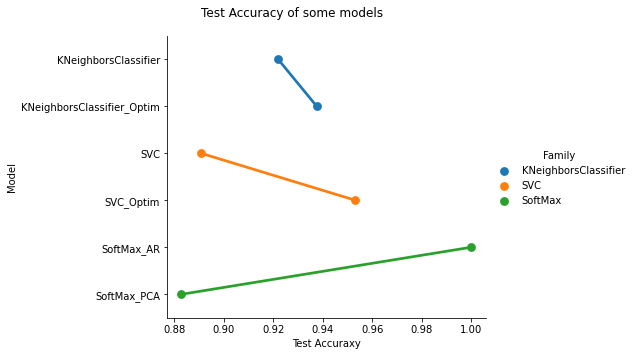

In [28]:
ax = sns.catplot(x="Test", y="Model", hue="Family", data=dfResults2, kind='point', height=5, aspect=1.5, legend_out=True, margin_titles=False);
ax.set_xlabels("Test Accuraxy")
ax.fig.suptitle("Test Accuracy of some models")
ax.fig.subplots_adjust(top=0.9)
pass;

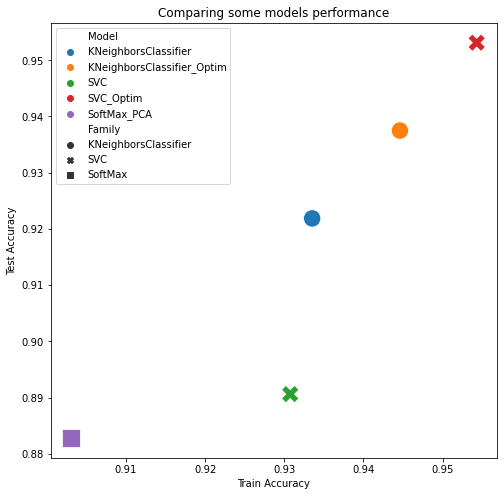

In [29]:
plt.subplots(figsize=(8,8))
ax = sns.scatterplot(x="Train", y="Test", hue="Model", style='Family', data=dfResults2[dfResults2['Model'] != 'SoftMax_AR'], s=300);
ax.set_xlabel('Train Accuracy');
ax.set_ylabel('Test Accuracy');
ax.set_title('Comparing some models performance');

### Notes:

1. Both fitted SVM and K-Nearest Neighbors models were based on the X2 Dataset, so we use the Softmax based on the PCA dimmensionallity reduction as being a referenece case for comparison

2. No SVM or k-NN model performed better than the Autoregression Softmax. It still looks like all the other methods loses a bit of accuracy as they're based on dimensionallity reduction

3. Both k-NN and SVM got a higher performance when "optimized" (This optimization was not exhaustive and only considered some runs of the fit method testing some combinations of some parameters and comparing the Test set accuracy)
    * SVM gain of accuracy: $ \frac{accuracy(optimized)}{accuracy(default)}-1 = \frac{0.9531}{0.8906}-1 = 7\% $
    
    * k-NN gain of accuracy: $ \frac{accuracy(optimized)}{accuracy(default)}-1 = \frac{0.9375}{0.9217}-1 = 1.7\% $

4. We noticed that as we change the size of the trainning set {10, 15, 20, 30% of X2} a few cells above, the models vary a lot their performance, leading into different best models/parameters conclusion. This can be related to the small size of the dataset and maybe can be adressed by further techniques like cross fold validation.
